# Dfsu - Export to shapefile

1. Read selected item and timestep from dfsu
2. Extract geometry
3. Create GeoPandas dataframe
4. Save to ESRI shapefile

In [1]:
# conda install geopandas

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mikeio

## Step 1. read the selected data

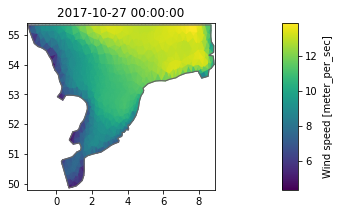

In [3]:
ds = mikeio.read("../tests/testdata/wind_north_sea.dfsu")
ws = ds["Wind speed"][0]
ws.plot();

## Step 2. extract geometry

In [4]:
shp = ds.geometry.to_shapely()
type(shp)

shapely.geometry.multipolygon.MultiPolygon

Geopandas does not like multipolygon, it should be a list of polygons

In [5]:
poly_list = [p for p in shp.geoms]

## Step 3. Create a geopandas dataframe

In [6]:
df = pd.DataFrame({'wind_speed':ws.to_numpy()})
df.head()

,wind_speed
0,9.530760
1,9.652719
2,9.806072
3,8.775489
4,11.013206


In [8]:
gdf = gpd.GeoDataFrame(df,geometry=poly_list, crs=4326)

## Step 4. Save to shapefile

In [10]:
gdf.to_file("wind_speed.shp")

## Step 5...
Do further work in QGIS

![QGIS](../images/dfsu_qgis.png)

Would you prefer to have this workflow to be a method on the `mikeio.Dfsu` class?

Post an issue on [GitHub](https://github.com/DHI/mikeio/issues) !

# Contour lines

In [11]:
# get coordinates
ec = ds.geometry.element_coordinates
lon = ec[:,0]
lat = ec[:,1]

In [12]:
# Select item and timestep
m = ds.Wind_speed[0].to_numpy()

In [13]:
# Interpolate to cartesian grid
from  scipy.interpolate import griddata
numcols, numrows = 200, 200
xi = np.linspace(lon.min(), lon.max(), numcols)
yi = np.linspace(lat.min(), lat.max(), numrows)
xi, yi = np.meshgrid(xi, yi)

grid_z = griddata(points=ec[:,0:2],values=m,xi=(xi,yi),method='cubic')

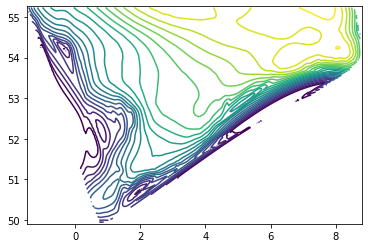

In [14]:
contour_levels=np.arange(4, 14, 0.5)
cn = plt.contour(xi,yi,grid_z,levels=contour_levels)

In [15]:
from shapely.geometry import LineString

poly_list = []

for collection,level in zip(cn.collections,contour_levels):
    for p in collection.get_paths():
        v = p.vertices
        x = v[:,0]
        y = v[:,1]
        poly = LineString([(i[0], i[1]) for i in zip(x,y)])
        if(poly.is_empty):
            print(f"{i} is empty")
        poly_list.append(dict(wind_speed = level, poly = poly))

In [16]:
# Clip to domain
domain = ds.geometry.to_shapely().buffer(0)
for p in poly_list:
    p['poly'].intersection(domain)

In [17]:
# Create GeoDataframe
df = pd.DataFrame({'wind_speed':[p['wind_speed'] for p in poly_list]})
gdf = gpd.GeoDataFrame(df,geometry=[p['poly'] for p in poly_list], crs=4326)
gdf.head()

,wind_speed,geometry
0,4.0,"LINESTRING (3.14064 51.02428, 3.15122 51.03832..."
1,4.0,"LINESTRING (-1.06282 54.23755, -1.06232 54.239..."
2,4.0,"LINESTRING (-1.06630 54.28629, -1.06339 54.293..."
3,4.0,"LINESTRING (4.76818 52.16071, 4.75442 52.16810..."
4,4.0,"LINESTRING (5.59430 52.38263, 5.59568 52.38330..."


In [18]:
gdf.explore(column='wind_speed')

In [16]:
# export shapefile
gdf.to_file("wind_speed_contours.shp")

![QGIS](../images/dfsu_qgis_contours.png)

# Clean up

In [17]:
import os

files = ["wind_speed","wind_speed_contours"]

exts = ["cpg","dbf","shp","shx"]

for file in files:
    for ext in exts:
        filename = f"{file}.{ext}"
        if os.path.exists(filename): os.remove(filename)